In [1]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

In [2]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_treatments=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False)
df = data["df"]
df

Z0        Z1        W0        W1        W2        W3        W4     v0  \
0     0.0  0.175977 -0.247243  0.281943  0.426054  0.216893  0.125273   True   
1     0.0  0.202411  0.735359 -0.233177 -0.625218 -1.343564  0.824562  False   
2     1.0  0.365221  0.218050  1.004444  1.992870 -0.111223  1.582561   True   
3     1.0  0.019529 -0.641241  0.468970 -0.282602 -2.675308 -0.420766  False   
4     0.0  0.780707  1.239219 -0.647022  0.404963 -1.338026  1.730947   True   
...   ...       ...       ...       ...       ...       ...       ...    ...   
9995  1.0  0.965415 -0.264492 -0.188378  0.023504  0.120437  0.658457   True   
9996  1.0  0.279023  0.465142  1.390620 -1.302512  0.146130  0.989465   True   
9997  1.0  0.114541 -1.084096  0.994722 -1.660565 -0.204126  0.007740   True   
9998  1.0  0.423770  0.197923  0.369854 -1.533987 -1.116071 -0.017451   True   
9999  0.0  0.633067 -0.871789  0.291233 -0.711324 -1.396924  0.242281  False   

              y  
0     10.114907  
1      3.892600  
2     18.405635  
3     -5.698173  
4     18.472320  
...         ...  
9995  10.308590  
9996  17.312783  
9997   5.886257  
9998   9.968296  
9999  -4.441309  

[10000 rows x 9 columns]

# Identifying the causal estimand

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


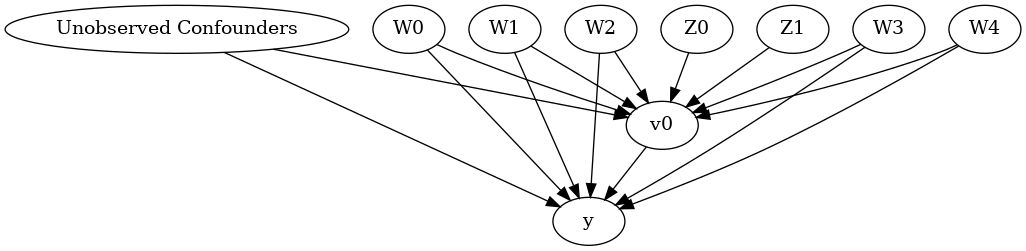

In [3]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"],
        logging_level = logging.INFO
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [4]:
identified_estimand = model.identify_effect()
print(identified_estimand)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
  d                                 
─────(Expectation(y|W2,W3,W4,W0,W1))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W4,W0,W1,U) = P(y|v0,W2,W3,W4,W0,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



# Method 1: Regression

In [5]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W4+W0+W1
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W2+W3+W4+W0+W1
Target units: ate

## Estimate
Mean value: 10.000169558604
p-value: [0.]

Causal Estimate is 10.000169558604


# Method 2: Stratification

In [8]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W4+W0+W1


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W2+W3+W4+W0+W1
Target units: att

## Estimate
Mean value: 10.110149974830438

Causal Estimate is 10.110149974830438


/home/emanuele/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/emanuele/.local/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


# Method 3: Matching

In [9]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W4+W0+W1
/home/emanuele/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W2+W3+W4+W0+W1
Target units: atc

## Estimate
Mean value: 10.221536643228793

Causal Estimate is 10.221536643228793


# Method 4: Weighting

In [10]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W4+W0+W1


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W2+W3+W4+W0+W1
Target units: ate

## Estimate
Mean value: 11.13243390103702

Causal Estimate is 11.13243390103702


/home/emanuele/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


# Method 5: Instrumental Variable

In [11]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params = {'iv_instrument_name': 'Z0'})
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in the same way by common causes of ['v0'] and y



*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in the same way by common c

# Method 6: Regression Discontinuity

In [12]:
causal_estimate_regdist = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity",
        method_params={'rd_variable_name':'Z1',
                       'rd_threshold_value':0.5,
                       'rd_bandwidth': 0.1})
print(causal_estimate_regdist)
print("Causal Estimate is " + str(causal_estimate_regdist.value))

INFO:dowhy.causal_estimator:Using Regression Discontinuity Estimator
INFO:dowhy.causal_estimator:
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(y, local_rd_variable))⋅Expectation(Derivative(v0, local

              -1
_rd_variable))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['local_treatment'] is affected in the same way by common causes of ['local_treatment'] and local_outcome
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome local_outcome is affected in the same way by common causes of ['local_treatment'] and local_outcome



      local_rd_variable  local_treatment  local_outcome
5              0.579369             True       6.182109
12             0.525900             True       9.232053
14             0.589345            False      -8.605936
20             0.501043            False      -1.944533
22             0.571747             True      11.142052
...                 ...              ...            ...
9980           0.557687             True      13.171500
9982           0.552006             True       9.227103
9990           0.401830             True      10.706051
9994           0.410125             True       4.026863
9998           0.423770             True       9.968296

[2047 rows x 3 columns]
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusi